# 2. Modeling with a GEO at the US State granularity

We can use epymorph's GEO system to dynamically fetch data from external data sources to suit our modeling experiment.

First we construct the geo, then we will run simulations with two movement models and inspect the difference.

We constructed the SIRH model ourselves in the previous part, but epymorph's IPM library already includes it, so we can reference it from there as well.

In [1]:
from epymorph import *
from epymorph.geo import *
from epymorph.geo.adrio import adrio_maker_library
from epymorph.geo.cache import save_to_cache
from epymorph.geo.dynamic import DynamicGeo
from epymorph.geo.util import convert_to_static_geo
from epymorph.geography.us_census import StateScope

spec = DynamicGeoSpec(
    attributes=[
        AttributeDef('label', str, Shapes.N),
        AttributeDef('geoid', str, Shapes.N),
        AttributeDef('centroid', CentroidType, Shapes.N),
        AttributeDef('population', int, Shapes.N),
        AttributeDef('median_income', int, Shapes.N),
        AttributeDef('commuters', int, Shapes.NxN),
    ],
    time_period=Year(2020),
    scope=StateScope.in_states_by_code(["AZ", "NM", "CO", "UT"], year=2020),
    source={
        'label': 'Census:name',
        'geoid': 'Census',
        'centroid': 'Census',
        'population': 'Census',
        'median_income': 'Census',
        'commuters': 'Census',
    },
)

geo = DynamicGeo.from_library(spec, adrio_maker_library)

# It's convenient to pre-fetch the data but this isn't mandatory.
geo = convert_to_static_geo(geo)

# Let's inspect a few values...
print(f"nodes: {geo.nodes}")
print(f"name: {geo['label']}")
print(f"population: {geo['population']}")

# Then save it to a cache so we don't bother the Census API too much.
save_to_cache(geo, 'demo-four-states')

nodes: 4
name: ['Arizona' 'Colorado' 'New Mexico' 'Utah']
population: [7174064 5684926 2097021 3151239]


## Centroids movement

Our first movement model is a simple distance kernel using node centroid coordinates (longitude/latitude).

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 4 geo nodes
|####################| 100% 
Runtime: 0.093s


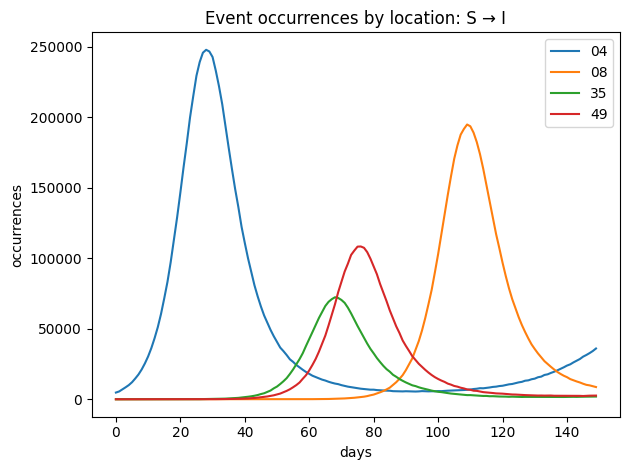

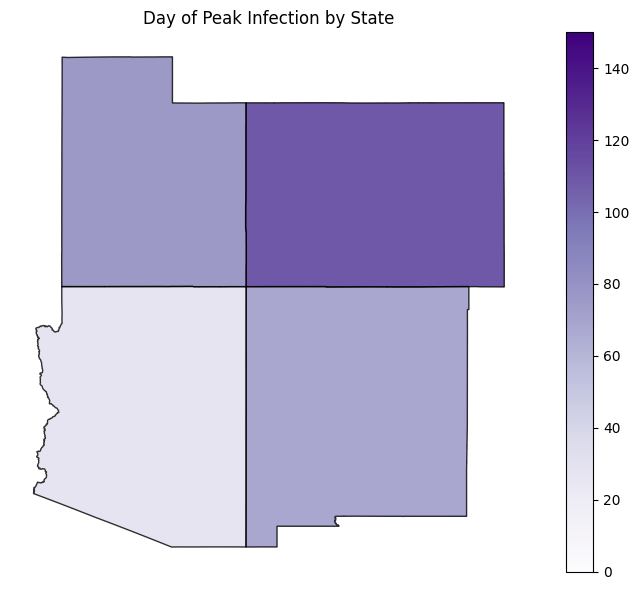

In [2]:
import numpy as np

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.plots import map_data_by_state

geo = load_from_cache('demo-four-states')
if geo is None:
    raise Exception("Oops, we need to cache the demo geo first (see above cell).")

rume = Rume.single_strata(
    ipm=ipm_library['sirh'](),
    mm=mm_library['centroids'](),
    scope=geo.spec.scope,
    params={
        'beta': 0.45,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'phi': 40.0,
        'population': geo['population'],
        'centroid': geo['centroid'],
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging(sim):
    output = sim.run()

EVENT_S_TO_I = rume.ipm.events_by_dst("I")[0]

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array([
    # argmax gives us an index, but the index is equal to the tau step index
    # so just need to floor-div by number of tau steps to get day
    float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
    for n in range(geo.nodes)
])

map_data_by_state(
    geo=geo,
    data=day_of_peak_infection,
    title='Day of Peak Infection by State',
    vmin=0,
    vmax=output.dim.days,
    cmap='Purples',
)

## Commuters movement

Now switch to a different movement model, incorporating the Census Bureau's ACS Commuting Flows data, and run the simulation again.

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-05-31 (150 days)
• 4 geo nodes
|####################| 100% 
Runtime: 0.110s


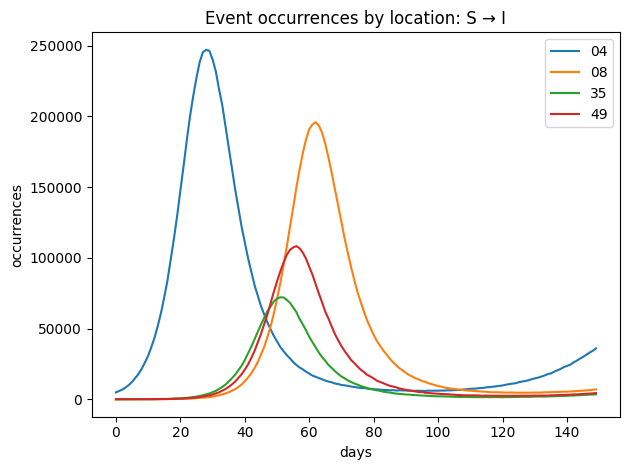

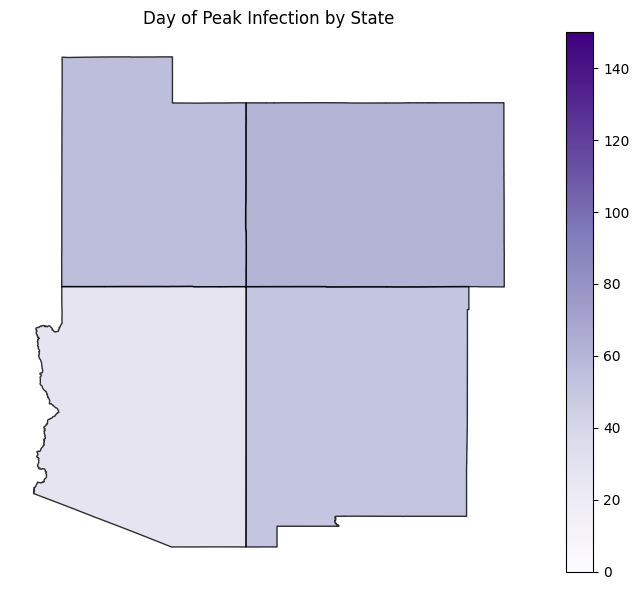

In [3]:
import numpy as np

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.plots import map_data_by_state

geo = load_from_cache('demo-four-states')
if geo is None:
    raise Exception("Oops, we need to cache the demo geo first (see above cell).")

rume = Rume.single_strata(
    ipm=ipm_library['sirh'](),
    mm=mm_library['pei'](),
    scope=geo.spec.scope,
    params={
        'beta': 0.45,
        'gamma': 0.25,
        'xi': 0.0111,
        'hospitalization_prob': 0.1,
        'hospitalization_duration': 7.0,
        'move_control': 0.9,
        'theta': 0.1,
        'population': geo['population'],
        'centroid': geo['centroid'],
        'commuters': geo['commuters'],
    },
    time_frame=TimeFrame.of("2015-01-01", 150),
    # Initialize the infection in Arizona with 10k individuals.
    init=init.SingleLocation(location=0, seed_size=10_000),
)

sim = BasicSimulator(rume)
with sim_messaging(sim):
    output = sim.run()

EVENT_S_TO_I = rume.ipm.events_by_dst("I")[0]

plot_event(output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array([
    # argmax gives us an index, but the index is equal to the tau step index
    # so just need to floor-div by number of tau steps to get day
    float(np.argmax(output.incidence[:, n, EVENT_S_TO_I])) // output.dim.tau_steps
    for n in range(geo.nodes)
])

map_data_by_state(
    geo=geo,
    data=day_of_peak_infection,
    title='Day of Peak Infection by State',
    vmin=0,
    vmax=output.dim.days,
    cmap='Purples',
)